In [2]:
# EJEMPLO DE MODELO PK

# This script integrates a set of differential equations that   
# describe the pharmacokinetic:
#
#
#     kabs            k1           kon
#  I  --->   Iblood  ----> Itissue ---->  EI 
#            |       <----         <----
#            | kout   k2           koff
#           \/
#
#
# kout = sum of the rates of elimination and metabolism.
# kon  = 
# Concentrations are in mol/L, and time is in seconds.
#
# All species are described in the system vector X:
#   X = [Iblood, Itissue, f]
#
# All rates are described in the rate vector R:
#   R = [kabs, kout, k1, k2, kon, koff]
#
#   where [E] = (1-f)Etot and [EI] = f*Etot
#     and Etot is the total concentration of target protein

In [ ]:
import numpy as np
import pylab as p
import matplotlib.pyplot as plt
from scipy import integrate

Integration successful.
[[0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [9.86467253e-06 1.08130766e-10 8.55869102e-03]
 [9.77972531e-06 1.16843239e-10 1.70535144e-02]
 ...
 [1.39625811e-06 1.39699151e-05 9.99928415e-01]
 [1.38599063e-06 1.38672651e-05 9.99927884e-01]
 [1.37582105e-06 1.37655943e-05 9.99927349e-01]]


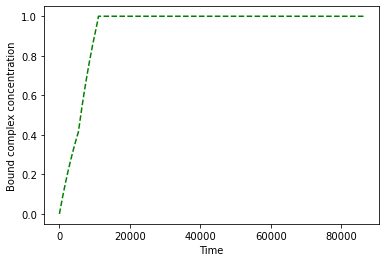

In [4]:
# set time parameters of interest
tmin = 0      # first time point of interest
tmax = 86400  # last time point of interest
tres = 1000    # time resolution of output

# set dose profile
dose_conc = [1,0.75,0.40] # in M
dose_time = [0,5400,10800] # in s

I0 = 1  # initial concentration of unabsorbed compound
Etot = 1  # total concentration of protein 
X0 = np.array([0,0,0])
R = np.array([0.0001,0.05,10,1,1E6,0.001])

# functions

def I_of_t (t):
    isum = 0
    for dt, conc in zip(dose_time, dose_conc):
        isum += step(t-dt)*conc*np.exp(-R[0]*(t-dt))
    return isum

def step(x):
    return 1 * (x > 0)

def dIblood_dt (X,t):
    dIb_dt = R[0]*I_of_t(t) - X[0]*(R[1] + R[2]) + X[1]*R[3]
    return dIb_dt

def dItissue_dt (X,t):
    dIt_dt = R[2]*X[0] - X[1]*(R[3] + (1.-X[2])*Etot*R[4]) + X[2]*R[5]*Etot
    return dIt_dt

def df_dt (X,t):
    df_dt = X[1]*R[4] - X[2]*(X[1]*R[4] + R[5])
    return df_dt

def dX_dt(X,t):
    return np.array([dIblood_dt(X,t), dItissue_dt(X,t), df_dt(X,t)])

t = np.linspace(tmin,tmax,tres)
plt.plot(t,I_of_t(t))
plt.xlabel("Time")
plt.ylabel("Unabsorbed drug concentration")
p.savefig('I_of_t.png', bbox_inches='tight')

X, infodict = integrate.odeint(dX_dt,X0,t,full_output=True);
print(infodict['message'])
print(X)

plt.figure(1)
plt.clf()
plt.plot(t,X.T[0],'r')
plt.xlabel("Time")
plt.ylabel("I_blood")
p.savefig('Iblood.png', bbox_inches='tight')

plt.clf()
plt.plot(t,X.T[1],'b')
plt.xlabel("Time")
plt.ylabel("I_tissue")
p.savefig('Itissue.png', bbox_inches='tight')

plt.clf()
plt.plot(t,X.T[2],'g')
plt.xlabel("Time")
plt.ylabel("Fraction of complex bound")
p.savefig('frac_bound.png', bbox_inches='tight')

plt.clf()
EI = Etot*X.T[2]  # get EI concentration as a function of time
E = Etot*(1.-X.T[2])  # get free E concentration as a function of time
plt.plot(t,EI,'g--')
plt.xlabel("Time")
plt.ylabel("Bound complex concentration")
p.savefig('bound.png', bbox_inches='tight')